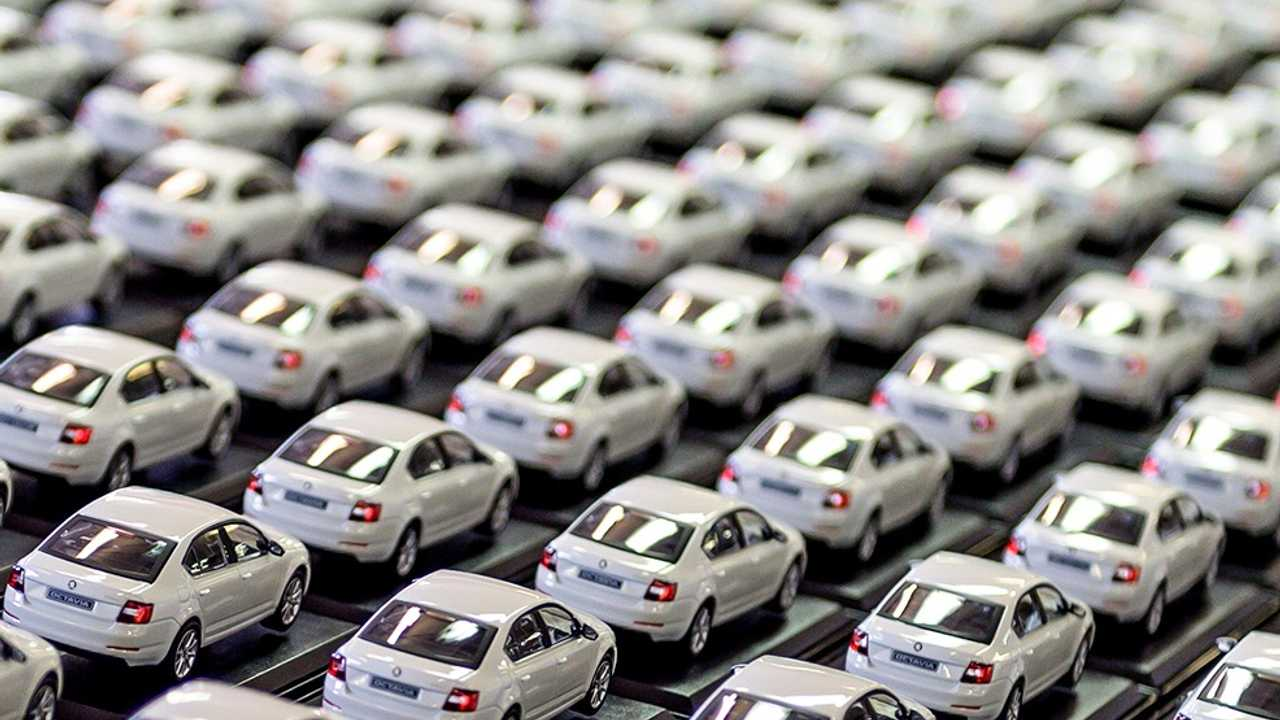

Цель проекта - классификация изображений.

In [ ]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-lsmpm8t6
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-lsmpm8t6
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=5b0d50314d3dfb863964da9565e34b64c95e16f7e5963d0da80f3faf128799c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-uuxqonjo/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-cci4ey8_
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-cci4ey8_
     |████████████████████████████████| 50 kB 1.5 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18421 sha256=666fa68f58989b90689289cd6f6ada7da97d994b01cc779f2c249e3db9817cc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lw37il3f/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import efficientnet.keras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score


import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


'''функция графика истории обучения'''


def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
           

'''функция, выводящая все уникальные значения и их количество'''
    
    
def cat_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    sns.catplot(x=column, kind="count", palette="Blues", data=df)
    
    
print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [ ]:
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

RANDOM_SEED = 42

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/" # рабочая директория

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


### Датасет небольшой, в нем нет пропущенных значений или изображений

,Category
1,1971
8,1765
6,1733
5,1631
0,1613
3,1528
2,1458
4,1400
9,1255
7,1207


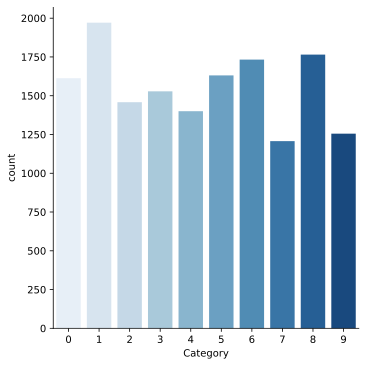

In [ ]:
cat_values(train_df, 'Category')

### Распределение относительно равномерное. Меньше всего машин седьмой и девятой категорий  
### Взглянем на примеры фотографий

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['__notebook__.ipynb', 'test_upload', 'train']


Пример картинок (random sample)


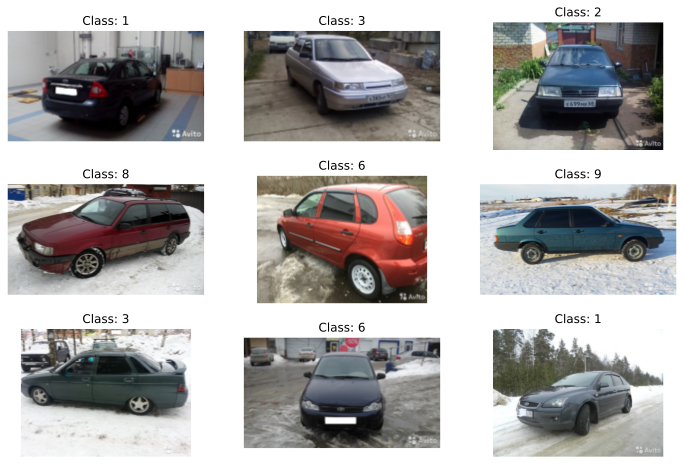

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

### Видим изображения в темное время суток, таких настроек в моей аугментации, к сожалению, нет.

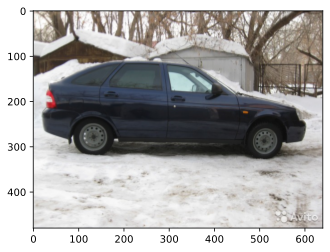

(640, 480)

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Я сильной разницы между некоторыми классами не вижу, но на мой непрофессиональный взгляд, возможно собрано 9 популярных моделей

In [ ]:
#train_files, test_files, train_labels, test_labels = \
#    train_test_split(train_df['Id'], train_df['Category'], test_size=0.15, random_state=42, stratify=train_df['Category'])

#train_files = pd.DataFrame(train_files)
#test_files = pd.DataFrame(test_files)
#train_files['Category'] = train_labels
#test_files['Category'] = test_labels

#train_files.shape, test_files.shape

### К сожалению, так и не разобралась, как совместить train_test_split и ImageDataAugmentor: меняю на flow_from_dataframe, но при этом из директории файлы ни в какую не извлекаются.  
### Но боюсь, разбиение выйдет неравномерным, что скажется на результате
train_generator = train_datagen.flow_from_dataframe(  
dataframe = train_files,  
directory = PATH+'train/',  #здесь еще пробовала оставить только PATH  
x_col="Id",  
y_col="Category",  
target_size=(IMG_SIZE, IMG_SIZE),  
batch_size=BATCH_SIZE,  
class_mode='raw',  
shuffle=True,   
subset='training') 

# АУГМЕНТАЦИЯ ДАННЫХ

Загружаем и устанавливаем нужные настройки в библиотеке albumentations

In [ ]:
transform = A.Compose([
                       A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.5),
                       A.RandomRotate90(p=0.5),
                       #A.RandomScale(p=0.5),
                       A.Blur(p=0.5),
                       A.ChannelDropout(p=0.5),
                       A.ChannelShuffle(p=0.5),
                       A.HueSaturationValue(p=0.5),
                       A.Downscale(scale_min = 0.75, scale_max = 0.99),
                       A.ISONoise(color_shift=(0.01,0.3), intensity=(0.1,0.5),p=0.5),
                       A.MotionBlur(p=0.5),
                       A.OpticalDistortion(p=0.5)
])

Заворачиваем в обертку под keras

In [ ]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=transform,
        preprocess_input=None,
        validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
train_df['Category']

0        0
1        0
2        0
3        0
4        0
        ..
15556    9
15557    9
15558    9
15559    9
15560    9
Name: Category, Length: 15561, dtype: int64

# Строим модель
 
## Загружаем предобученную сеть Efficient

### Выбор пал на эту сеть, так как размер у нее сопоставим с Xception, что использовался в baseline (75 MB и 88 MB соответственно)  
### А судя по этим данным [ссылка на github](https://github.com/rwightman/pytorch-image-models/blob/master/results/results-imagenet.csv) и результаты у нее в среднем лучше

In [ ]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape = input_shape)

71892992/71892840 [==============================] - 1s 0us/step


In [ ]:
print(len(base_model.layers))

467


### Мы не станем обучать сразу всю модель

In [ ]:
base_model.trainable = False

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add (L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,136,418
Trainable params: 462,090
Non-trainable params: 17,674,328
______________________________________

In [ ]:
print(len(model.layers))

6


In [ ]:
len(model.trainable_variables)

6

# Fit

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

LearningRateScheduler не стала в итоге использовать, так как с этим должен справляться оптимизатор Adam  
[Learning Rate Schedules and Adaptive Learning Rate Methods](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

Так как количество элох небольшое, patience для изменения будет равным 1, ждать больше для ухудшения метрик - недальновидно

In [ ]:
#def step_decay(epoch):
#    initial_lrate = 0.1
#   drop = 0.5
#    epochs_drop = 10.0
#    lrate = initial_lrate * math.pow(drop,  
#           math.floor((1+epoch)/epochs_drop))
#    return lra
#callback_schedule_lr = LearningRateScheduler(step_decay)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=1,
                              min_lr=1e-10)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

callback_checkpoint = ModelCheckpoint('best_model.hdf5' , 
                                      monitor = 'val_accuracy' , 
                                      verbose = 1  , 
                                      mode = 'max')

callbacks_list = [callback_checkpoint,
                 callback_early_stopping,
                 callback_reduce_lr]

In [ ]:
# Обучаем:

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
827/827 [==============================] - 258s 293ms/step - loss: 2.3619 - accuracy: 0.2496 - val_loss: 1.7303 - val_accuracy: 0.3912

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 234s 283ms/step - loss: 1.8736 - accuracy: 0.3350 - val_loss: 1.6162 - val_accuracy: 0.4113

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 231s 280ms/step - loss: 1.7851 - accuracy: 0.3619 - val_loss: 1.5744 - val_accuracy: 0.4388

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 235s 284ms/step - loss: 1.7261 - accuracy: 0.3769 - val_loss: 1.5290 - val_accuracy: 0.4401

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 234s 283ms/step - loss: 1.7164 - accuracy: 0.3761 - val_loss: 1.5464 - val_accuracy: 0.4315

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==========================

In [ ]:
# Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


146/146 [==============================] - 35s 242ms/step - loss: 1.4416 - accuracy: 0.4848
Accuracy: 48.48%


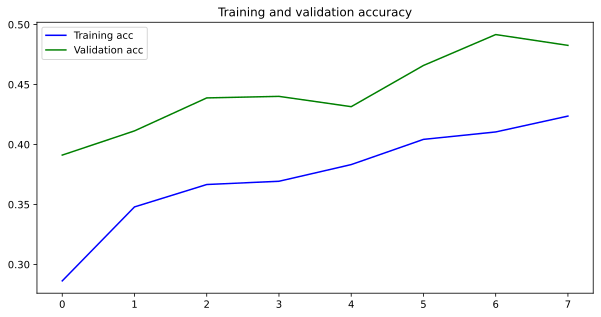

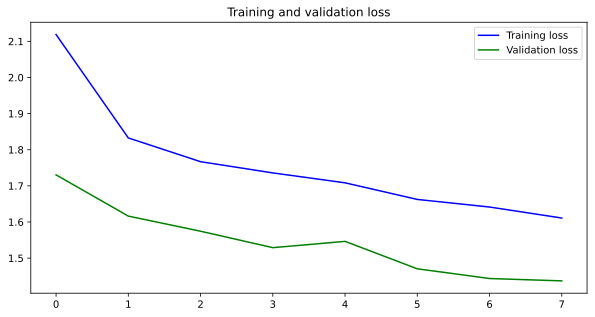

In [ ]:
plot_history(history)

### Модель явно переобучена.  
### Возможно, тестовая выборка показывает результаты выше, чем у обучающей, может быть в том, что в модели есть выпадающий слой, что делает валидационные данные устойчивыми
### Будем постепенно разворачивать базовую модель

## Step 2  
## Transfer Learning and Fine Tuning

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  467


### Разморозим половину модели и чуть изменим гиперпараметры

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
len(base_model.trainable_variables)

208

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f0000ab8d50> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0000b73dd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0000b79c50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0001640910> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7efff8802e10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7effdd3d7fd0> True


In [ ]:
LR  = 1e-4
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,136,418
Trainable params: 16,604,838
Non-trainable params: 1,531,580
____________________________________

In [ ]:
# Обучаем

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 277s 316ms/step - loss: 1.7233 - accuracy: 0.3983 - val_loss: 1.0033 - val_accuracy: 0.6432

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 256s 310ms/step - loss: 1.1114 - accuracy: 0.6121 - val_loss: 0.7719 - val_accuracy: 0.7282

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 257s 311ms/step - loss: 0.8738 - accuracy: 0.6897 - val_loss: 0.5996 - val_accuracy: 0.7815

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 262s 317ms/step - loss: 0.7375 - accuracy: 0.7436 - val_loss: 0.5500 - val_accuracy: 0.8038

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 264s 319ms/step - loss: 0.6430 - accuracy: 0.7728 - val_loss: 0.4484 - val_accuracy: 0.8454

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==========================

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 34s 235ms/step - loss: 0.3959 - accuracy: 0.8626
Accuracy: 86.26%


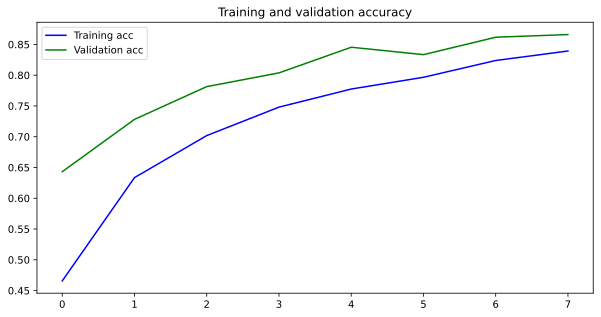

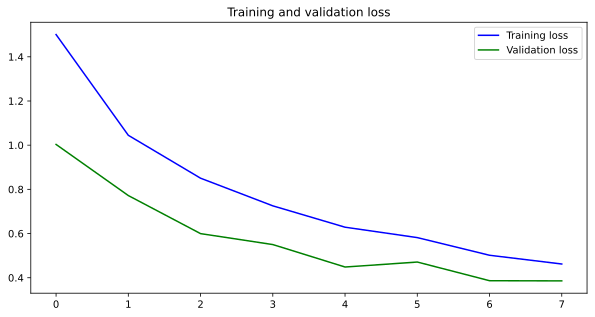

In [ ]:
plot_history(history)

### Улушчения на лицо. Разморозим следующую партию 

## Step 3

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
len(base_model.trainable_variables)

311

In [ ]:
LR                   = 1e-4
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 18,136,418
Trainable params: 17,827,948
Non-trainable params: 308,470
______________________________________

In [ ]:
# Обучаем


history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 285s 324ms/step - loss: 0.4972 - accuracy: 0.8246 - val_loss: 0.3855 - val_accuracy: 0.8583

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 274s 331ms/step - loss: 0.4448 - accuracy: 0.8419 - val_loss: 0.3653 - val_accuracy: 0.8712

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 274s 332ms/step - loss: 0.3804 - accuracy: 0.8690 - val_loss: 0.3568 - val_accuracy: 0.8695

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 275s 333ms/step - loss: 0.3626 - accuracy: 0.8766 - val_loss: 0.3405 - val_accuracy: 0.8798

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 277s 335ms/step - loss: 0.3440 - accuracy: 0.8840 - val_loss: 0.3285 - val_accuracy: 0.8875

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==========================

In [ ]:
model.save('../working/model_last.hdf5') 
model.load_weights('best_model.hdf5') 

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 35s 240ms/step - loss: 0.2919 - accuracy: 0.9004
Accuracy: 90.04%


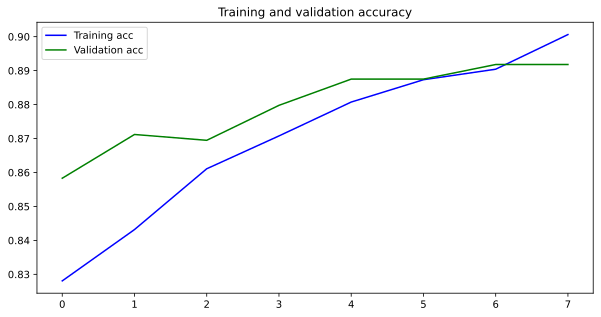

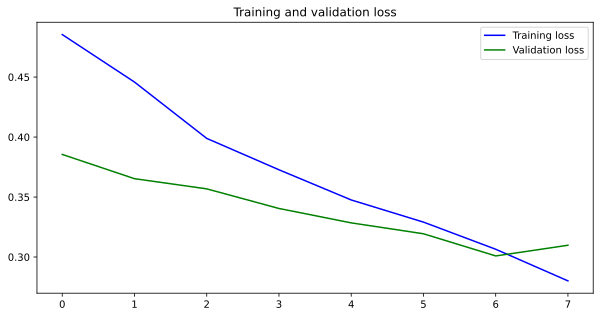

In [ ]:
plot_history(history)

Графики стали хуже, идет переобучение

## Step 4

Дообучим всю модель

In [ ]:
# попробуем увеличить количество эпох, так как accuracy увеличивалась медленно
EPOCHS               = 8
LR                   = 1e-5

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 341s 391ms/step - loss: 0.2875 - accuracy: 0.9000 - val_loss: 0.2523 - val_accuracy: 0.9180

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 313s 378ms/step - loss: 0.2574 - accuracy: 0.9083 - val_loss: 0.2214 - val_accuracy: 0.9163

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 311s 376ms/step - loss: 0.2176 - accuracy: 0.9242 - val_loss: 0.2343 - val_accuracy: 0.9188

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 317s 383ms/step - loss: 0.2150 - accuracy: 0.9247 - val_loss: 0.2580 - val_accuracy: 0.9146

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 312s 378ms/step - loss: 0.2153 - accuracy: 0.9266 - val_loss: 0.2227 - val_accuracy: 0.9236

Epoch 00005: saving model to best_model.hdf5
Epoch 00005: early stopping


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 34s 231ms/step - loss: 0.2501 - accuracy: 0.9201
Accuracy: 92.01%


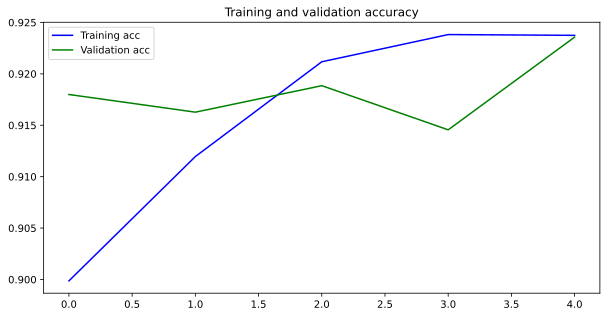

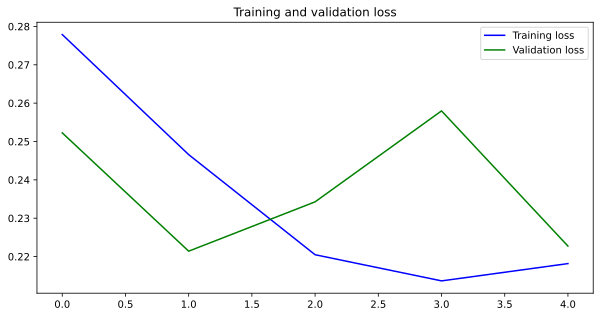

In [ ]:
plot_history(history)

Loss очень не стабильный, как и accuracy. Нужно усложнять модель для лучшего результата, поработать над аугментацией и скоростью обучения, все же вручную настраивать - это не то  
Попробуем использовать еще одну технику для улучшения метрики

# Step 5

### Увеличенный размер картинки   
Попробуем еще один метод


In [ ]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая , иначе не поместится в память на GPU
LR                   = 1e-4

IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
transform_less = A.Compose([
                       A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.5),
                       #A.RandomRotate90(p=0.5),
                       #A.RandomScale(p=0.5),
                       #A.Blur(p=0.5),
                       A.ChannelDropout(p=0.5),
                       #A.ChannelShuffle(p=0.5),
                       A.HueSaturationValue(p=0.5),
                       #A.Downscale(scale_min = 0.75, scale_max = 0.99),
                       #A.ISONoise(color_shift=(0.01,0.3), intensity=(0.1,0.5),p=0.5),
                       A.MotionBlur(p=0.5),
                       #A.OpticalDistortion(p=0.5)
])

In [ ]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment=transform_less,
        preprocess_input=None,
        validation_split=VAL_SPLIT)

test_datagen = ImageDataAugmentor(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [ ]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape = input_shape)
base_model.trainable = True

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add (L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
# Обучаем

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
3308/3308 [==============================] - 1347s 401ms/step - loss: 0.5420 - accuracy: 0.8397 - val_loss: 0.1367 - val_accuracy: 0.9605

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
3308/3308 [==============================] - 1316s 398ms/step - loss: 0.2643 - accuracy: 0.9173 - val_loss: 0.1546 - val_accuracy: 0.9532

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
3308/3308 [==============================] - 1315s 397ms/step - loss: 0.1752 - accuracy: 0.9463 - val_loss: 0.0970 - val_accuracy: 0.9721

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
3308/3308 [==============================] - 1321s 399ms/step - loss: 0.1241 - accuracy: 0.9634 - val_loss: 0.0978 - val_accuracy: 0.9708

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
3308/3308 [==============================] - 1326s 401ms/step - loss: 0.1019 - accuracy: 0.9699 - val_loss: 0.0978 - val_accuracy: 0.9717

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
3308/3308 [===

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 42s 71ms/step - loss: 0.0972 - accuracy: 0.9751
Accuracy: 97.51%


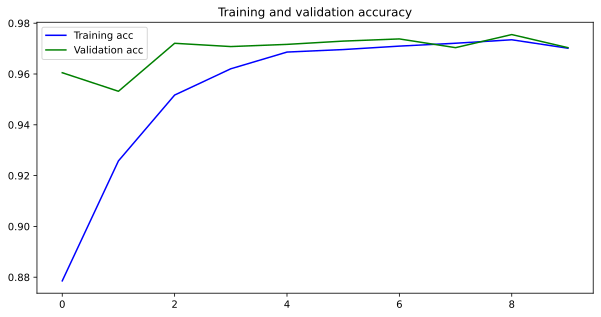

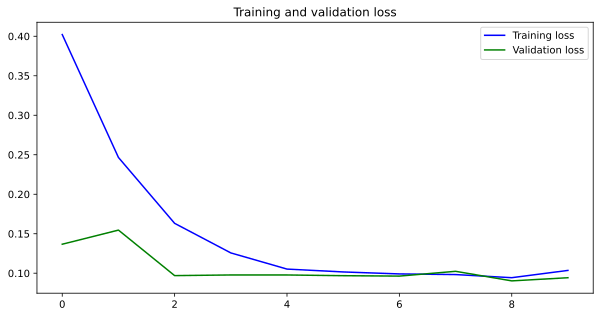

In [ ]:
plot_history(history)

Графики выглядят отличными, сабмит покажет, не переобучились ли мы
Возможно, я перестаралась с настройками albumentations, и меньше в данном случае - лучше

# Предсказываем на тестовых данных 

In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 114s 67ms/step


In [ ]:
filenames_with_dir = test_sub_generator.filenames

submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


В целом на удивление вполне неплохо отработала модель, посмотрим каким будет сабмит

# TTA

### Теперь опробуем Test Time Augmentation

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment=transform,
    validation_split=VAL_SPLIT,
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 356s 213ms/step


In [ ]:
test_sub_generator.reset()
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission1 = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission1['Id'] = submission1['Id'].replace('test_upload/','')
print('Save submit')

Save submit


In [ ]:
scores = model.evaluate_generator(test_sub_generator, steps = len(test_sub_generator),verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1669/1669 [==============================] - 322s 192ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [ ]:
submission1.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,5
2,31197.jpg,0
3,93598.jpg,5
4,87877.jpg,7


На удивление, TTA вообще никак не отработал. Где-то закралась ошибка, не могу ее увидеть

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH,ignore_errors=True)

In [ ]:
submission.to_csv('submission_1.csv', index=False)
submission1.to_csv('submission_TTA.csv', index=False)

Основной сабмит: 97.408
Интересное замечание: при первом сабмите из-за синтаксической ошибки, веса модели не прогрузились после самой первой операции(первого обучения), и на выходе сабмит был 97.468